# Survival analysis

Make a dictionary where we have a table for each cancer type that's ready to plug into the plotter. Format: One column of days until last contact or death (duration col), on column of vital status (event col), and a column of true/false for each event (attribute).

Then plot for each cancer type.

In [1]:
import pandas as pd
import numpy as np
import cptac
import cptac.utils as ut
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

## Prepare tables

In [2]:
dss = {
    "ccrcc": cptac.Ccrcc,
    "endometrial": cptac.Endometrial,
    "hnscc": cptac.Hnscc,
    "lscc": cptac.Lscc,
    "luad": cptac.Luad,
}

In [3]:
def prepare_plot_table(ds):
    
    # Load the followup data
    ds = ds()
    cancer_type = ds.get_cancer_type()
    
    if cancer_type in ["ovarian"]:
        fp = ds.get_clinical()
    else:
        fp = ds.get_followup()
    
    cancer_col_names = {
        "ccrcc": {
            "vital_status": "Vital Status",
            "last_contact": "Path Diag to Last Contact(Day)",
            "death": "Path Diag to Death(days)",
        },
        "endometrial": {
            "vital_status": "Vital Status",
            "last_contact": "Path Diag to Last Contact(Day)",
            "death": "Path Diag to Death(days)",
        },
        "hnscc": {
            "vital_status": "VITAL_STATUS",
            "last_contact": "PATHO_DIAG_TO_LAST_CONT_DAYS",
            "death": "PATHO_DIAG_TO_DEATH_DAYS",
        },
        # No followup df or clinical with this info
        "lscc": {
            
        },
        "luad": {
            "vital_status": "Vital Status",
            "last_contact": "Path Diag to Last Contact(Day)",
            "death": "Path Diag to Death(days)",
        }
    }
    
    vital_status_col = cancer_col_names[cancer_type]["vital_status"]
    last_contact_col = cancer_col_names[cancer_type]["last_contact"]
    death_col = cancer_col_names[cancer_type]["death"]
    
    # Rename columns for consistency
    fp = fp[[vital_status_col, last_contact_col, death_col]].\
    rename(columns={
        vital_status_col: "vital_status",
        last_contact_col: "days_to_last_contact",
        death_col: "days_to_death"
    })
    
    # Only keep rows where the death column is not NaN
    fp = fp[fp["vital_status"].notna()]
    
    # Only keep rows where at least one of the days_to_last_contact and days_to_death columns is not NaN
    fp = fp[(fp["days_to_last_contact"].notna() | fp["days_to_death"].notna())]
    
    # Fill NaNs in days_to_last_contact and days_to_death columns with zeros
    fp["days_to_last_contact"] = fp["days_to_last_contact"].fillna(0)
    fp["days_to_death"] = fp["days_to_death"].fillna(0)

    # Take care of multiple entries for each patient
    fp = fp.groupby("Patient_ID").agg(
        death=("vital_status", min), # This will select Deceased over Living
        days_to_last_contact=("days_to_last_contact", max),
        days_to_death=("days_to_death", max)
    )
    
    # Combine the days until last contact and days until death columns
    # We previously replaced NaNs with zeros, so those will be given lowest priority
    fp = fp.assign(days_to_last_contact_or_death=fp["days_to_last_contact"].combine(fp["days_to_death"], max))
    
    # Drop the other two
    fp = fp.drop(columns=["days_to_last_contact", "days_to_death"])
    
    # Fill vals
    fp["death"] = fp["death"].replace({"Deceased": True, "Living": False})
    
    # Load the residuals
    event = pd.read_csv(f"{cancer_type}_residuals.tsv.gz", sep="\t", index_col=0)
    
#     event = event.assign(
#         both=event["8p_loss"] & event["8q_gain"],
#         neither=~(event["8p_loss"] | event["8q_gain"])
#     )
    
    # Join the two
    joined = fp.join(event, how="inner")
    
    # Check
#    assert joined.index.duplicated().sum() == 0
    
    return joined

### Data example

The cell below shows the format we need our data in for the survival analysis. You need three columns:
- Event column (whether they have passed away): Boolean
- Duration column (days until death or last contact): Numeric
- Covariate column (whether each patient had the event): Boolean

In [16]:
prepare_plot_table(cptac.Luad).head()

,death,days_to_last_contact_or_death,Gene,Proteomics,Tissue,Transcriptomics,m,b,orth_resid,intersect_x,intersect_y,above_reg_line
Patient_ID,,,,,,,,,,,,
C3L-00001,False,1065.0,AACS,-1.1998,Tumor,2.6953,3.121565,-9.790151,0.053937,2.746666,-1.216255,True
C3L-00001,False,1065.0,AADAC,-1.6826,Tumor,-3.3578,1.546065,-1.114865,2.511100,-1.249310,-3.046379,True
C3L-00001,False,1065.0,AAGAB,-0.8179,Tumor,3.9955,2.586757,-10.347059,0.290709,3.724347,-0.713077,False
C3L-00001,False,1065.0,AAMDC,-0.8053,Tumor,2.6009,4.773432,-14.420181,0.245981,2.841654,-0.855736,True
C3L-00001,False,1065.0,AAMP,-0.1899,Tumor,5.0072,6.081416,-32.501973,0.301993,5.305191,-0.238900,True


## Plot individual variables

In [4]:
def plot_single_var_survival(cancer_type, df, above_reg_col, gene):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(f"{cancer_type} - {gene}")
    cph.print_summary()
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_event_count = df[above_reg_col].sum()
    no_event_count = df[above_reg_col].size - has_event_count
    
    plot_title = f"{cancer_type} survival: {above_reg_col}\n{deceased_count} deceased, {living_count} living\n {has_event_count} with event, {no_event_count} without event"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=above_reg_col, 
        values=[False, True],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

ccrcc - AARS                              


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.63
         time fit was run = 2021-10-07 16:14:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.55       1.73       0.61            -0.64             1.74                 0.53                 5.69

                  z    p   -log2(p)
covariate                          
above_reg_line 0.91 0.37       1.45
---
Concordance = 0.56
Partial AIC = 107.25
log-likelihood ratio test = 0.85 on 1 df
-log2(p) of ll-ratio test = 1.48

endometrial - AARS                              


<lifelines.CoxPHFitter: fitted with 94 total observations, 88 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 94
number of events observed = 6
   partial log-likelihood = -23.68
         time fit was run = 2021-10-07 16:14:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.65       1.92       0.83            -0.98             2.29                 0.38                 9.84

                  z    p   -log2(p)
covariate                          
above_reg_line 0.79 0.43       1.21
---
Concordance = 0.60
Partial AIC = 49.36
log-likelihood ratio test = 0.60 on 1 df
-log2(p) of ll-ratio test = 1.19

luad - AARS                               


<lifelines.CoxPHFitter: fitted with 100 total observations, 86 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 100
number of events observed = 14
   partial log-likelihood = -56.90
         time fit was run = 2021-10-07 16:15:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.28       1.33       0.55            -0.79             1.36                 0.45                 3.89

                  z    p   -log2(p)
covariate                          
above_reg_line 0.51 0.61       0.72
---
Concordance = 0.53
Partial AIC = 115.79
log-likelihood ratio test = 0.26 on 1 df
-log2(p) of ll-ratio test = 0.71

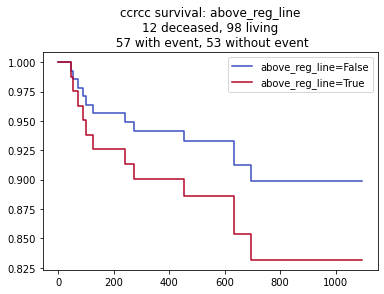

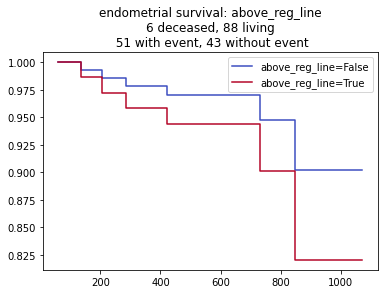

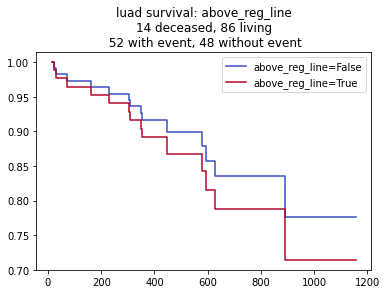

In [16]:
for cancer_type, ds in dss.items():
    gene_name = 'AARS'
    if cancer_type == 'lscc':
        continue
    df = prepare_plot_table(ds)
    #for i,g in df.groupby(["Gene"]):
        #sel_df = g[["death", "days_to_last_contact_or_death", "above_reg_line"]]
        #plot_single_var_survival(cancer_type, sel_df, "above_reg_line", i)
    g = df[df['Gene']==gene_name] 
    #print(g)
    if g.shape[0] > 0:
        sel_df = g[["death", "days_to_last_contact_or_death", "above_reg_line"]]
        plot_single_var_survival(cancer_type, sel_df, "above_reg_line", gene_name)

## Plot multiple variables

In [16]:
def plot_multi_var_survival(cancer_type, df, cnv_cols):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(cancer_type)
    cph.print_summary()
#     print(lifelines.statistics.proportional_hazard_test(cph, df))
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_8p_loss = df["8p_loss"].sum()
    no_8p_loss = df["8p_loss"].size - has_8p_loss
    
    has_8q_gain = df["8q_gain"].sum()
    no_8q_gain = df["8q_gain"].size - has_8q_gain
    
    plot_title = f"{cancer_type} survival: Chromosome 8\n{deceased_count} deceased, {living_count} living" +\
        f"\n{has_8p_loss} with 8p_loss, {no_8p_loss} without" +\
        f"\n{has_8q_gain} with 8q_gain, {no_8q_gain} without"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_cols, 
        values=[[a, b] for a in [True, False] for b in [True, False]],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

hnscc                                     


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 4)


<lifelines.CoxPHFitter: fitted with 95 total observations, 83 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 95
number of events observed = 12
   partial log-likelihood = -45.74
         time fit was run = 2020-10-08 04:11:29 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.54       0.58       0.58            -1.68             0.60                 0.19                 1.81
8q_gain     0.97       2.64       0.58            -0.17             2.11                 0.84                 8.28

              z    p   -log2(p)
covariate                      
8p_loss   -0.93 0.35       1.51
8q_gain    1.67 0.10       3.39
---
Concordance = 0.64
Partial AIC = 95.49
log-likelihood ratio test = 2.65 on 2 df
-log2(p) of ll-ratio test = 1.91

luad                                     


<lifelines.CoxPHFitter: fitted with 99 total observations, 85 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 99
number of events observed = 14
   partial log-likelihood = -56.02
         time fit was run = 2020-10-08 04:11:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.90       0.40       0.78            -2.44             0.63                 0.09                 1.88
8q_gain     0.20       1.23       0.70            -1.16             1.57                 0.31                 4.81

              z    p   -log2(p)
covariate                      
8p_loss   -1.16 0.25       2.01
8q_gain    0.29 0.77       0.38
---
Concordance = 0.59
Partial AIC = 116.04
log-likelihood ratio test = 1.57 on 2 df
-log2(p) of ll-ratio test = 1.14

ovarian                                     


<lifelines.CoxPHFitter: fitted with 97 total observations, 90 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 97
number of events observed = 7
   partial log-likelihood = -19.83
         time fit was run = 2020-10-08 04:11:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.50       1.66       0.74            -0.95             1.95                 0.39                 7.05
8q_gain     1.43       4.16       0.88            -0.30             3.16                 0.74                23.47

             z    p   -log2(p)
covariate                     
8p_loss   0.68 0.50       1.01
8q_gain   1.61 0.11       3.23
---
Concordance = 0.64
Partial AIC = 43.66
log-likelihood ratio test = 3.57 on 2 df
-log2(p) of ll-ratio test = 2.58

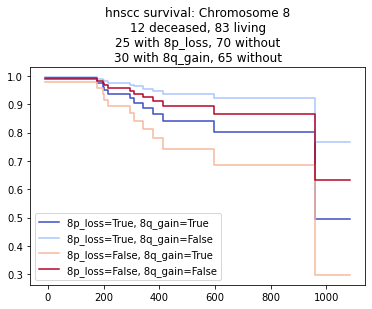

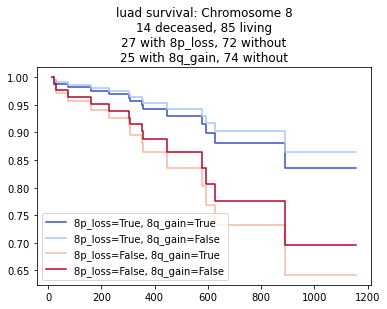

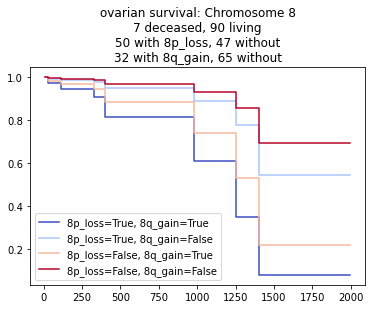

In [17]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type, ds in dss.items():
    df = prepare_plot_table(ds)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    plot_multi_var_survival(cancer_type, df, cnv_cols)

## Plot confidence intervals

In [9]:
def plot_cis(cancer_type, df):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    return cph.plot(ax=plt.axes(label=cancer_type))

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 4)


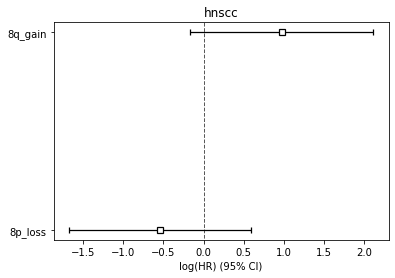

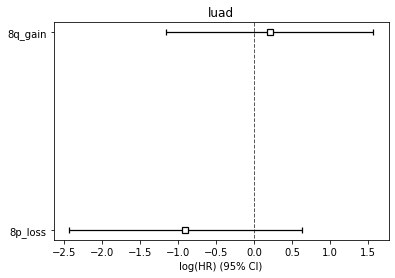

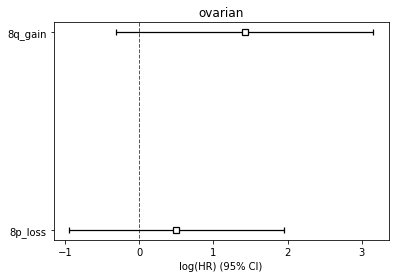

In [10]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type, ds in dss.items():
    df = prepare_plot_table(ds)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    ax = plot_cis(cancer_type, df)
    ax.set_title(cancer_type)
    plt.show()

## Calculate P values for proportional hazard test

In [11]:
def calc_pvals(cancer_type, df, cnv_cols):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_cols, 
        values=[[a, b] for a in [True, False] for b in [True, False]],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

In [12]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type, ds in dss.items():
    df = prepare_plot_table(ds)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    calc_pvals(cancer_type, df, cnv_cols)

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 4)


NameError: name 'plot_title' is not defined

### Where are the date of inital diagnosis columns for BRCA and Colon?

In [ ]:
br = cptac.Brca()

In [ ]:
co = cptac.Colon()

In [ ]:
pd.options.display.max_columns = None

In [ ]:
br.get_followup()

In [ ]:
co.get_followup()